Requirement: fsrs-optimizer >= 6.1.4

In [1]:
import numpy as np
import pandas as pd

import os
import sys

sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    0.4783,
    1.2172,
    9.7398,
    15.8796,
    6.8942,
    0.3659,
    3.2729,
    0.0099,
    1.4107,
    0.0061,
    0.5899,
    1.68,
    0.009,
    0.4049,
    1.2676,
    0.0,
    3.0064,
    0.3535,
    0.5764,
    0.2246,
    0.2205,
]


def generate_revlog_from_simulation(
    initial_parameters, learn_span, desired_retention_list, seed=2023
):
    flattened_revlogs = []
    deck_size = 10000
    for i, desired_retention in enumerate(desired_retention_list):
        _, _, _, _, _, revlogs = simulate(
            w=initial_parameters,
            request_retention=desired_retention,
            deck_size=deck_size,
            learn_span=learn_span,
            max_cost_perday=3600,
            learning_step_count=0,
            relearning_step_count=0,
            seed=seed,
            fuzz=True,
        )

        for day in revlogs:
            card_ids = revlogs[day]["card_id"]
            ratings = revlogs[day]["rating"]
            for card_id, rating in zip(card_ids, ratings):
                flattened_revlogs.append(
                    {
                        "card_id": card_id + i * deck_size,
                        "review_rating": int(rating),
                        "day": day,
                    }
                )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt

decay_list = []
trained_parameters = None


def train_and_evaluate(train_df, test_df):
    plt.close("all")
    sample_size = len(train_df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        train_df[train_df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=train_df, verbose=False)
    optimizer.init_w[20] = initial_parameters[20]
    optimizer.train(gamma=0, verbose=False)
    global trained_parameters
    trained_parameters = optimizer.w
    decay_list.append(optimizer.w[20])
    optimizer.dataset = test_df.copy()
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, trained_parameters):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset


def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30
sample size: 5576


  0%|          | 0/5576 [00:00<?, ?it/s]

  0%|          | 0/86305 [00:00<?, ?it/s]

loss before: 0.3395, loss after: 0.3285
RMSE(bins): 0.0193
AUC: 0.5385
0.4783 -> 0.3674: SMAPE=26.2268%
1.2172 -> 1.4183: SMAPE=15.2609%
9.7398 -> 9.3745: SMAPE=3.8223%
15.8796 -> 12.8503: SMAPE=21.0881%
6.8942 -> 6.6285: SMAPE=3.9297%
0.3659 -> 0.9105: SMAPE=85.3338%
3.2729 -> 3.4259: SMAPE=4.5680%
0.0099 -> 0.001: SMAPE=163.3028%
1.4107 -> 1.613: SMAPE=13.3810%
0.0061 -> 0.2833: SMAPE=191.5688%
0.5899 -> 0.5825: SMAPE=1.2624%
1.68 -> 1.6509: SMAPE=1.7473%
0.009 -> 0.039: SMAPE=125.0000%
0.4049 -> 0.4714: SMAPE=15.1775%
1.2676 -> 1.8673: SMAPE=38.2596%
3.0064 -> 1.8684: SMAPE=46.6891%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1038: SMAPE=71.9704%
Avg. SMAPE: 66.8977%
loss before: 0.3395, loss after: 0.3269
RMSE(bins): 0.0090
AUC: 0.5531
--------------------------------
learn_span: 60
sample size: 12468


  0%|          | 0/12468 [00:00<?, ?it/s]

  0%|          | 0/86305 [00:00<?, ?it/s]

loss before: 0.3395, loss after: 0.3281
RMSE(bins): 0.0172
AUC: 0.5384
0.4783 -> 0.3148: SMAPE=41.2306%
1.2172 -> 1.4452: SMAPE=17.1274%
9.7398 -> 10.1929: SMAPE=4.5463%
15.8796 -> 13.7134: SMAPE=14.6399%
6.8942 -> 6.5721: SMAPE=4.7838%
0.3659 -> 0.3283: SMAPE=10.8326%
3.2729 -> 3.4928: SMAPE=6.5004%
0.0099 -> 0.0257: SMAPE=88.7640%
1.4107 -> 1.581: SMAPE=11.3848%
0.0061 -> 0.2502: SMAPE=190.4799%
0.5899 -> 0.5842: SMAPE=0.9710%
1.68 -> 1.6225: SMAPE=3.4822%
0.009 -> 0.1201: SMAPE=172.1146%
0.4049 -> 0.4869: SMAPE=18.3898%
1.2676 -> 1.9168: SMAPE=40.7738%
3.0064 -> 2.0614: SMAPE=37.2943%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1002: SMAPE=75.0234%
Avg. SMAPE: 62.3853%
loss before: 0.3395, loss after: 0.3269
RMSE(bins): 0.0090
AUC: 0.5531
--------------------------------
learn_span: 120
sample size: 26598


  0%|          | 0/26598 [00:00<?, ?it/s]

  0%|          | 0/86305 [00:00<?, ?it/s]

loss before: 0.3395, loss after: 0.3271
RMSE(bins): 0.0108
AUC: 0.5473
0.4783 -> 0.3449: SMAPE=32.4101%
1.2172 -> 1.0885: SMAPE=11.1636%
9.7398 -> 10.769: SMAPE=10.0367%
15.8796 -> 17.3158: SMAPE=8.6530%
6.8942 -> 6.4693: SMAPE=6.3591%
0.3659 -> 0.2881: SMAPE=23.7920%
3.2729 -> 3.5725: SMAPE=8.7533%
0.0099 -> 0.0189: SMAPE=62.5000%
1.4107 -> 1.5649: SMAPE=10.3643%
0.0061 -> 0.1077: SMAPE=178.5589%
0.5899 -> 0.6014: SMAPE=1.9307%
1.68 -> 1.5922: SMAPE=5.3664%
0.009 -> 0.1157: SMAPE=171.1307%
0.4049 -> 0.4814: SMAPE=17.2628%
1.2676 -> 1.8542: SMAPE=37.5809%
3.0064 -> 2.4153: SMAPE=21.8050%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.103: SMAPE=72.6430%
Avg. SMAPE: 59.4838%
loss before: 0.3395, loss after: 0.3269
RMSE(bins): 0.0090
AUC: 0.5531
--------------------------------
learn_span: 240
sample size: 55632


  0%|          | 0/55632 [00:00<?, ?it/s]

  0%|          | 0/86305 [00:00<?, ?it/s]

loss before: 0.3395, loss after: 0.3271
RMSE(bins): 0.0100
AUC: 0.5485
0.4783 -> 0.384: SMAPE=21.8717%
1.2172 -> 1.2589: SMAPE=3.3682%
9.7398 -> 10.9096: SMAPE=11.3301%
15.8796 -> 18.6166: SMAPE=15.8684%
6.8942 -> 6.3796: SMAPE=7.7536%
0.3659 -> 0.0215: SMAPE=177.8007%
3.2729 -> 3.6107: SMAPE=9.8146%
0.0099 -> 0.0125: SMAPE=23.2143%
1.4107 -> 1.4661: SMAPE=3.8515%
0.0061 -> 0.0332: SMAPE=137.9135%
0.5899 -> 0.5951: SMAPE=0.8776%
1.68 -> 1.6057: SMAPE=4.5226%
0.009 -> 0.1729: SMAPE=180.2089%
0.4049 -> 0.518: SMAPE=24.5097%
1.2676 -> 2.1436: SMAPE=51.3602%
0.0 -> 0.0005: SMAPE=200.0000%
3.0064 -> 2.7255: SMAPE=9.8013%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1021: SMAPE=73.4036%
Avg. SMAPE: 69.8494%
loss before: 0.3395, loss after: 0.3269
RMSE(bins): 0.0090
AUC: 0.5531
--------------------------------
learn_span: 480
sample size: 114872


  0%|          | 0/114872 [00:00<?, ?it/s]

  0%|          | 0/86305 [00:00<?, ?it/s]

loss before: 0.3395, loss after: 0.3269
RMSE(bins): 0.0091
AUC: 0.5520
0.4783 -> 0.4239: SMAPE=12.0594%
1.2172 -> 1.2576: SMAPE=3.2649%
9.7398 -> 10.7987: SMAPE=10.3114%
15.8796 -> 18.2762: SMAPE=14.0333%
6.8942 -> 6.4568: SMAPE=6.5523%
0.3659 -> 0.0439: SMAPE=157.1498%
3.2729 -> 3.3652: SMAPE=2.7809%
0.0099 -> 0.0128: SMAPE=25.5507%
1.4107 -> 1.3128: SMAPE=7.1893%
0.0061 -> 0.0029: SMAPE=71.1111%
0.5899 -> 0.6635: SMAPE=11.7441%
1.68 -> 1.6829: SMAPE=0.1725%
0.009 -> 0.1206: SMAPE=172.2222%
0.4049 -> 0.4408: SMAPE=8.4900%
1.2676 -> 2.6221: SMAPE=69.6455%
0.0 -> 0.0044: SMAPE=200.0000%
3.0064 -> 2.9929: SMAPE=0.4501%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1182: SMAPE=60.4074%
Avg. SMAPE: 63.9286%
loss before: 0.3395, loss after: 0.3269
RMSE(bins): 0.0090
AUC: 0.5531
--------------------------------
learn_span: 960
sample size: 179905


  0%|          | 0/179905 [00:00<?, ?it/s]

  0%|          | 0/86305 [00:00<?, ?it/s]

loss before: 0.3395, loss after: 0.3270
RMSE(bins): 0.0091
AUC: 0.5510
0.4783 -> 0.4287: SMAPE=10.9372%
1.2172 -> 1.2093: SMAPE=0.6511%
9.7398 -> 11.08: SMAPE=12.8743%
15.8796 -> 19.4014: SMAPE=19.9643%
6.8942 -> 6.4094: SMAPE=7.2883%
0.3659 -> 0.0689: SMAPE=136.6145%
3.2729 -> 3.3323: SMAPE=1.7986%
0.0099 -> 0.0145: SMAPE=37.7049%
1.4107 -> 1.2166: SMAPE=14.7756%
0.0061 -> 0.0044: SMAPE=32.3810%
0.5899 -> 0.7219: SMAPE=20.1250%
1.68 -> 1.6986: SMAPE=1.1010%
0.009 -> 0.1535: SMAPE=177.8462%
0.4049 -> 0.4214: SMAPE=3.9937%
1.2676 -> 3.2451: SMAPE=87.6415%
0.0 -> 0.003: SMAPE=200.0000%
3.0064 -> 3.0774: SMAPE=2.3341%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1093: SMAPE=67.4348%
Avg. SMAPE: 64.0396%
loss before: 0.3395, loss after: 0.3269
RMSE(bins): 0.0090
AUC: 0.5531
--------------------------------
learn_span: 1920
sample size: 246805


  0%|          | 0/246805 [00:00<?, ?it/s]

  0%|          | 0/86305 [00:00<?, ?it/s]

loss before: 0.3395, loss after: 0.3270
RMSE(bins): 0.0094
AUC: 0.5510
0.4783 -> 0.3759: SMAPE=23.9756%
1.2172 -> 1.2387: SMAPE=1.7509%
9.7398 -> 11.4831: SMAPE=16.4285%
15.8796 -> 20.1251: SMAPE=23.5830%
6.8942 -> 6.39: SMAPE=7.5910%
0.3659 -> 0.062: SMAPE=142.0425%
3.2729 -> 3.2835: SMAPE=0.3233%
0.0099 -> 0.0112: SMAPE=12.3223%
1.4107 -> 1.1729: SMAPE=18.4084%
0.0061 -> 0.0037: SMAPE=48.9796%
0.5899 -> 0.7563: SMAPE=24.7214%
1.68 -> 1.7165: SMAPE=2.1493%
0.009 -> 0.1628: SMAPE=179.0454%
0.4049 -> 0.4233: SMAPE=4.4434%
1.2676 -> 3.7815: SMAPE=99.5781%
0.0 -> 0.0033: SMAPE=200.0000%
3.0064 -> 3.0699: SMAPE=2.0901%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.101: SMAPE=74.3390%
Avg. SMAPE: 66.2447%
loss before: 0.3395, loss after: 0.3269
RMSE(bins): 0.0090
AUC: 0.5531
--------------------------------


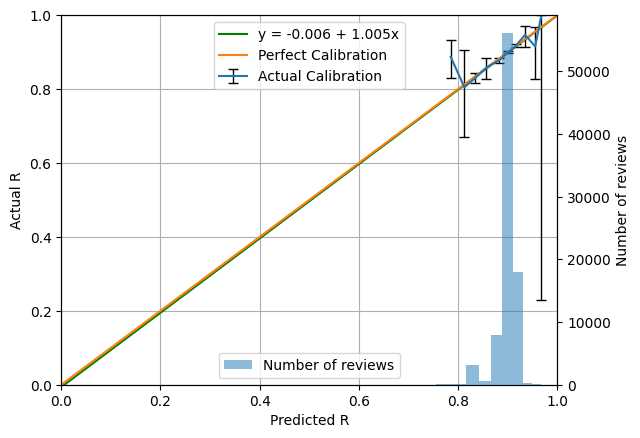

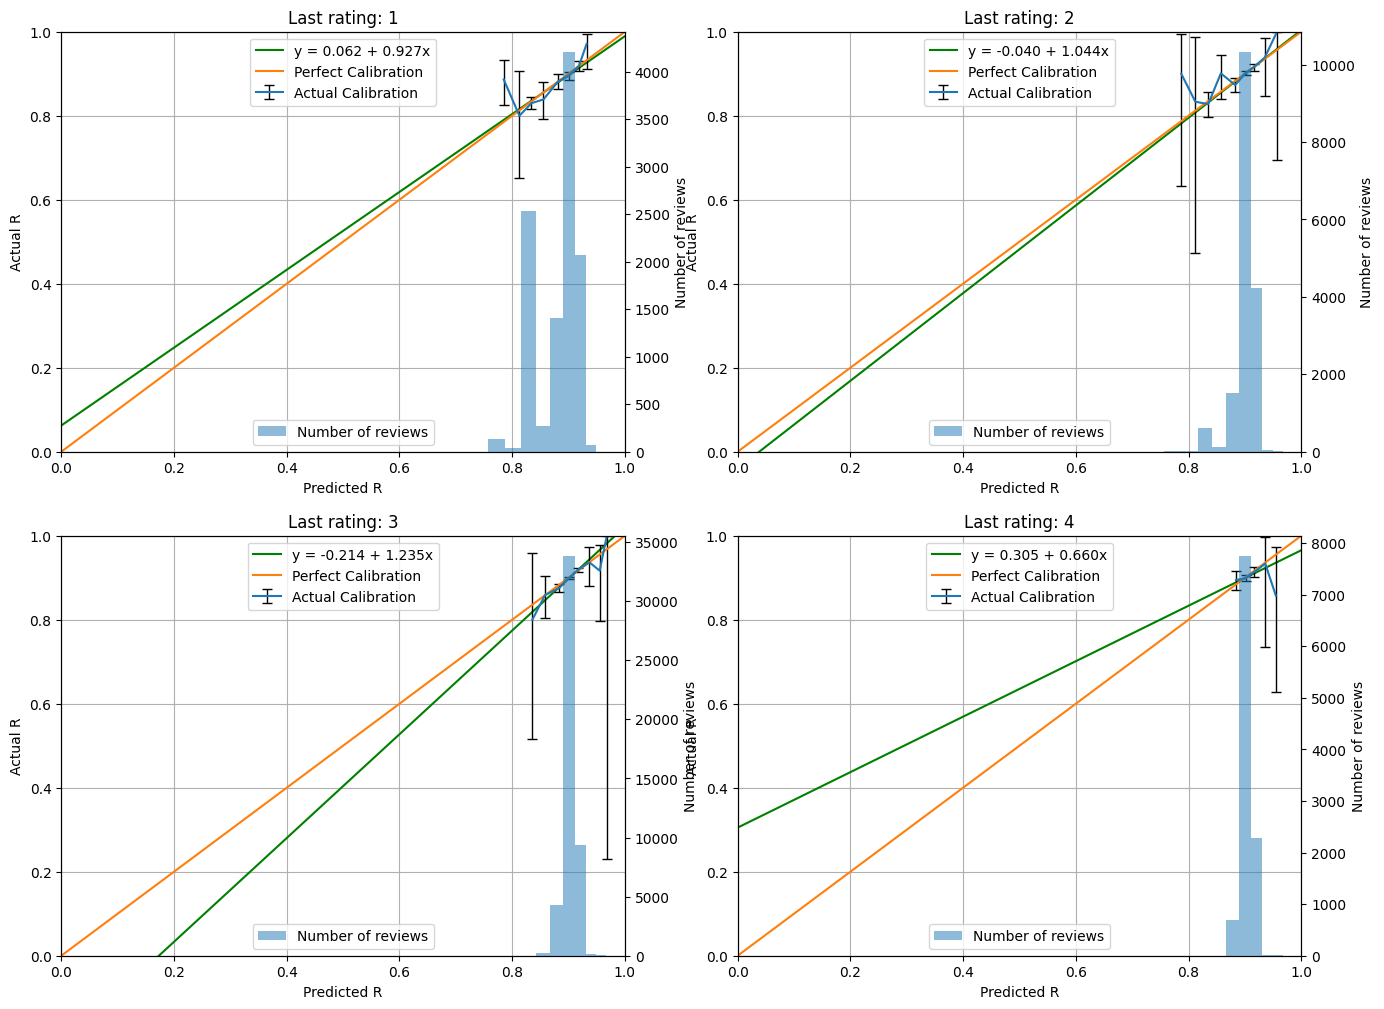

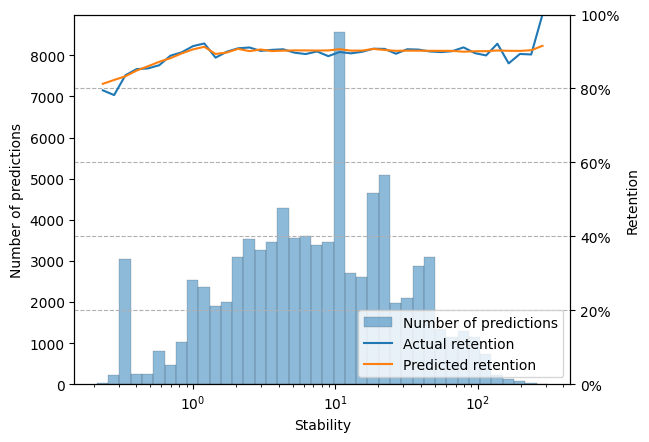

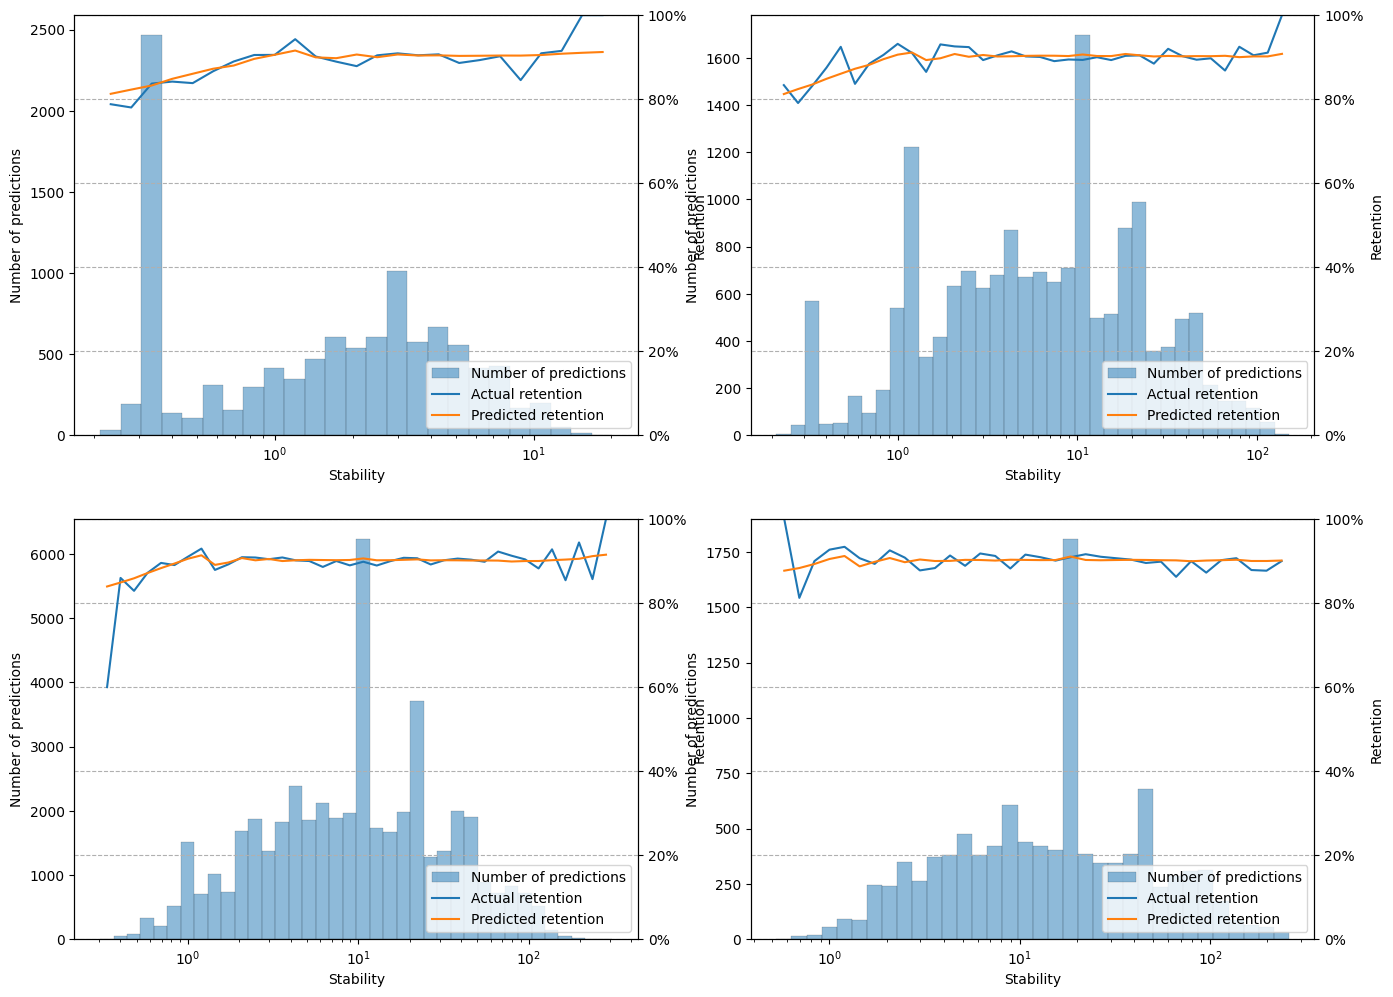

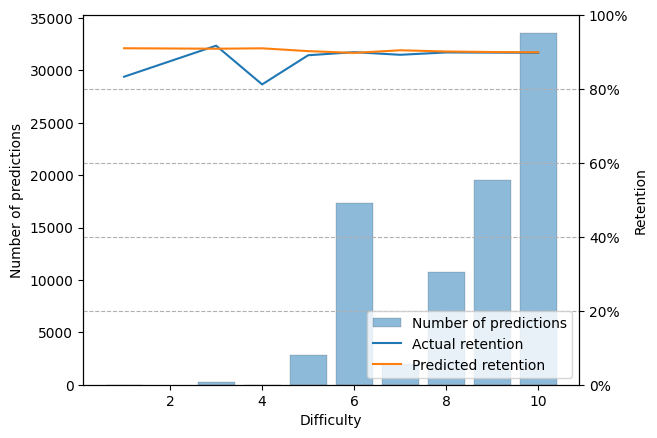

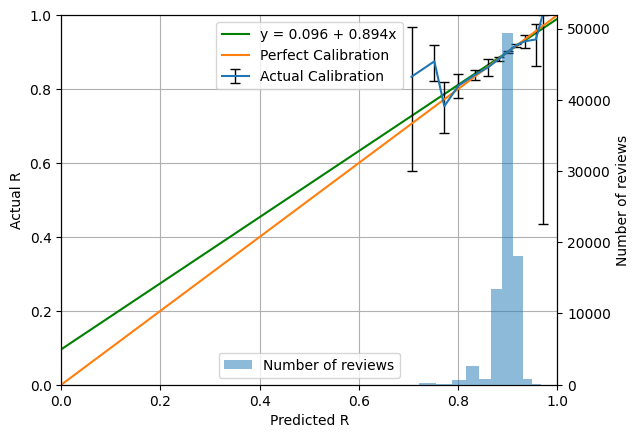

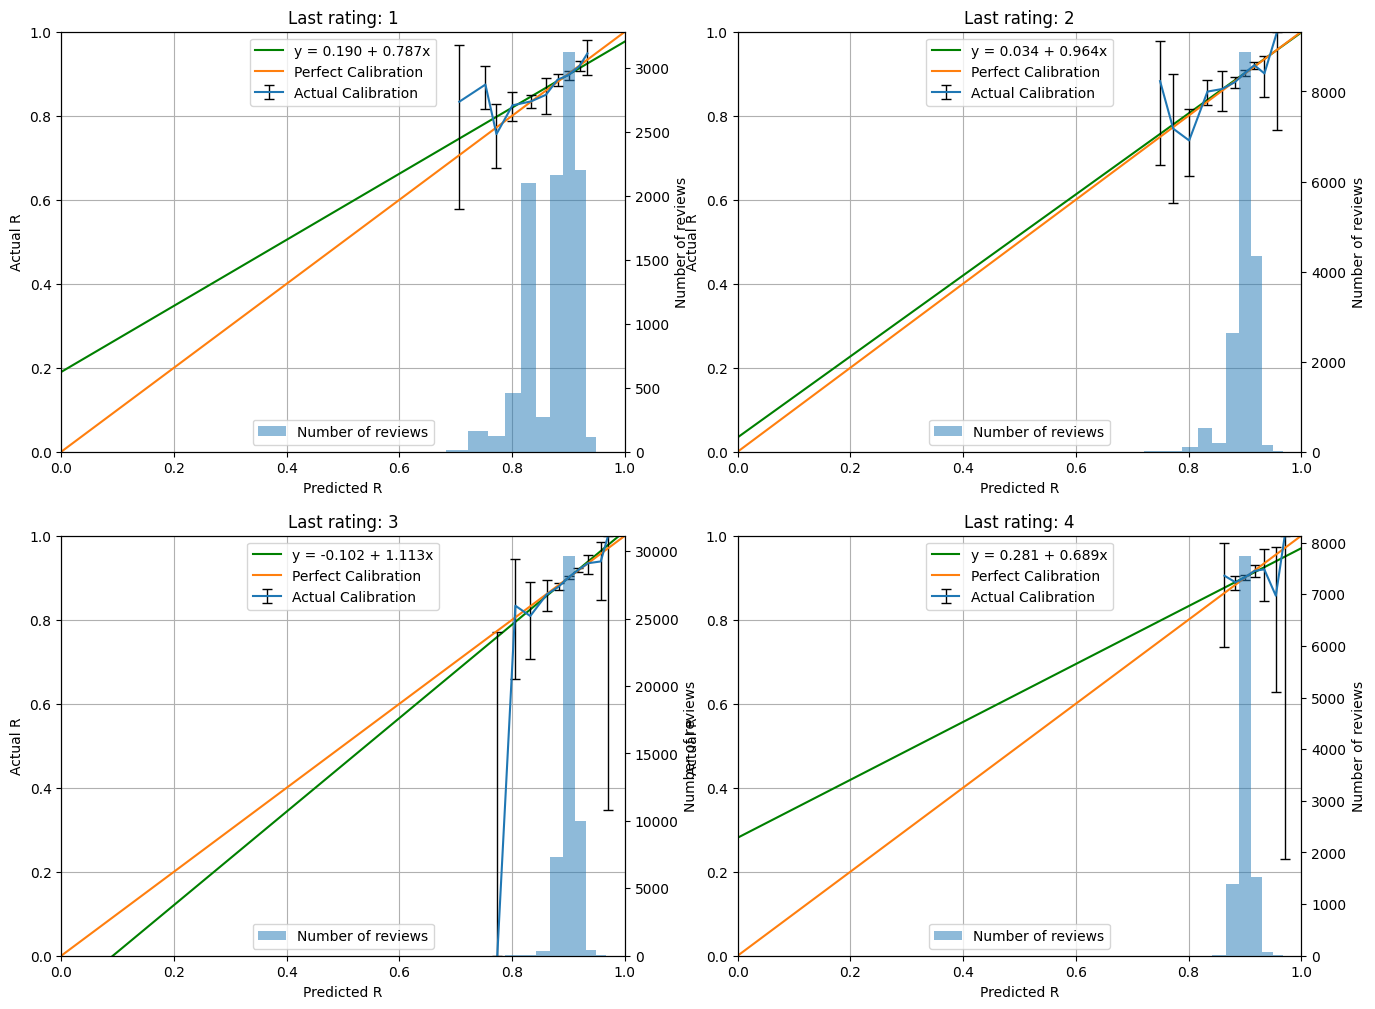

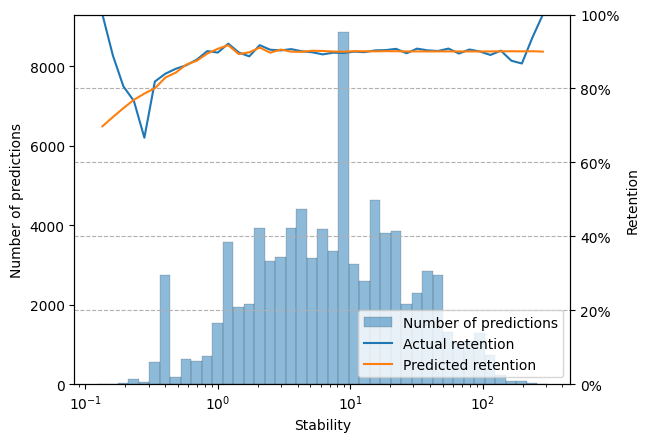

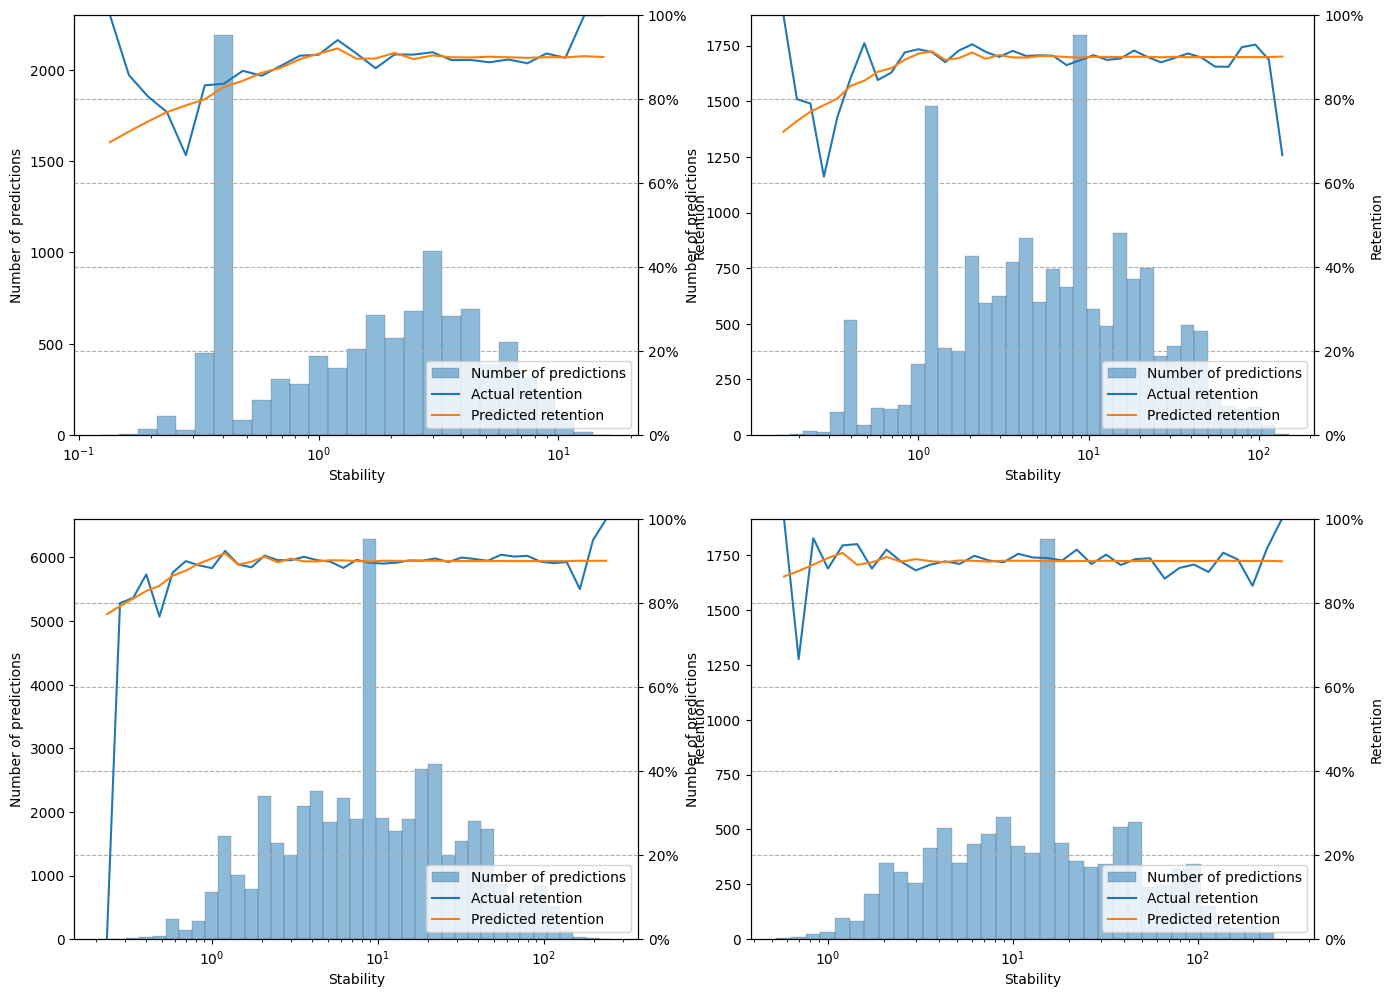

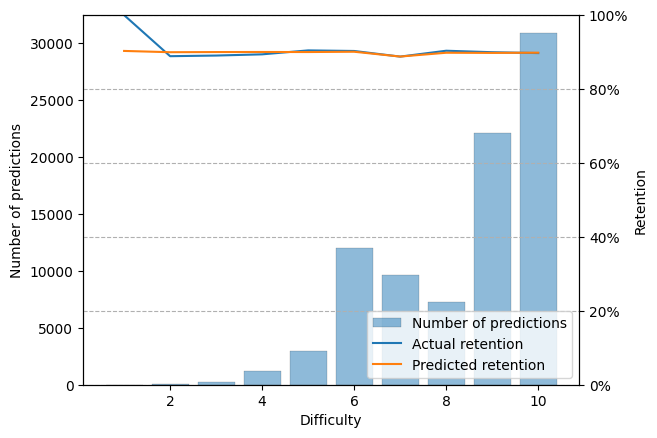

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960, 1920]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []


test_revlogs = generate_revlog_from_simulation(
    initial_parameters, learn_span=365, desired_retention_list=[0.9], seed=2023
)
test_df = preprocess_revlog(test_revlogs)

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    train_revlogs = generate_revlog_from_simulation(
        initial_parameters,
        learn_span=learn_span,
        desired_retention_list=[0.9],
        seed=2023,
    )
    train_df = preprocess_revlog(train_revlogs)
    if train_df.empty:
        continue
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(
        train_df, test_df
    )
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

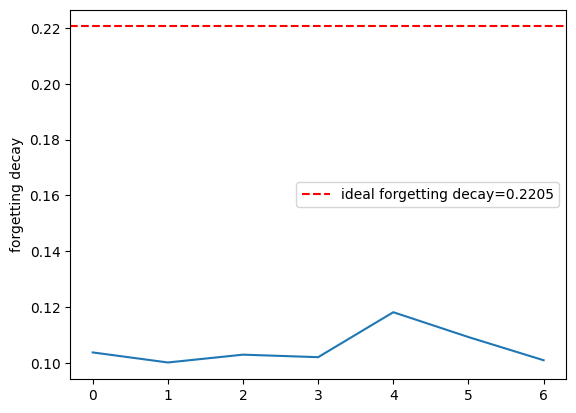

In [5]:
plt.plot(decay_list)
plt.axhline(
    y=initial_parameters[20],
    color="r",
    linestyle="--",
    label=f"ideal forgetting decay={initial_parameters[20]:.4f}",
)
plt.ylabel("forgetting decay")
plt.legend()
plt.show()

In [6]:
np.set_printoptions(precision=6, suppress=True)
print(
    f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}"
)
print(
    f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}"
)
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [0.001646 0.001194 0.000231 0.000164 0.000046 0.000082 0.00011 ]
RMSE(bins) (trained - ideal): [0.010314 0.008175 0.001792 0.000973 0.0001   0.000057 0.000403]
AUC (trained - ideal): [-0.01458  -0.014673 -0.005762 -0.004623 -0.001051 -0.002038 -0.002112]


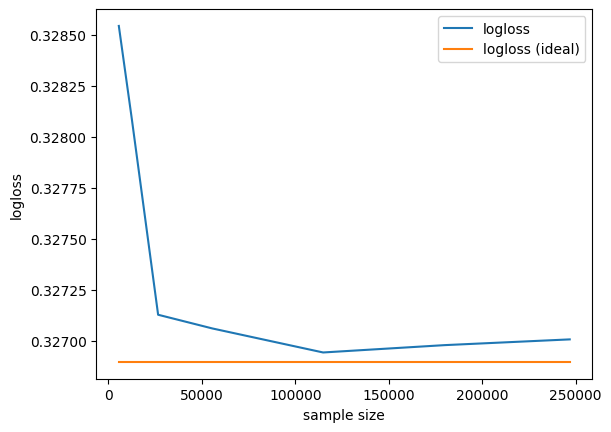

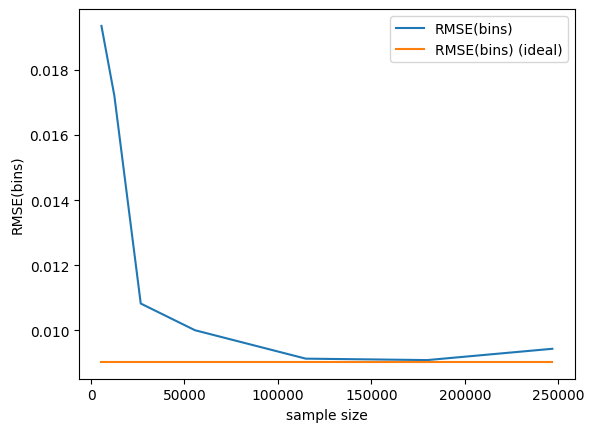

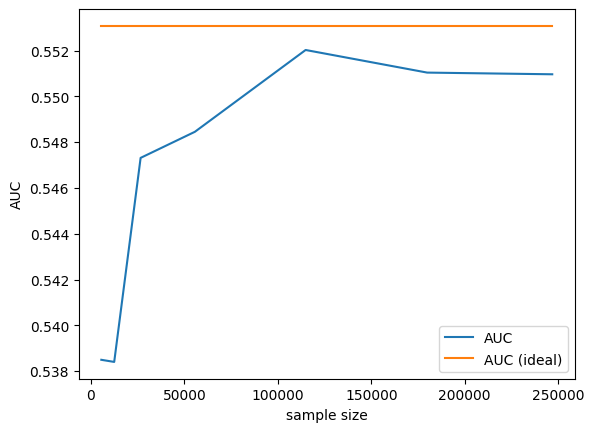

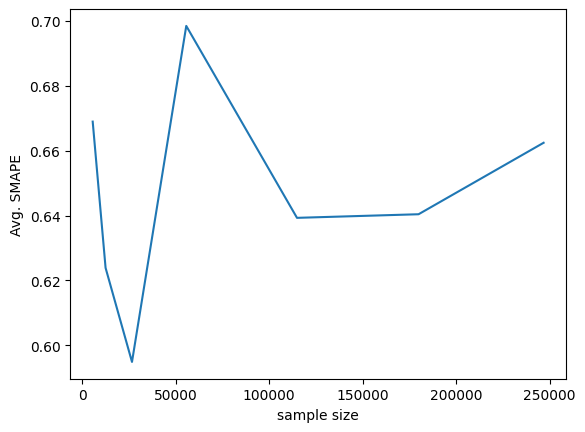

In [7]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()

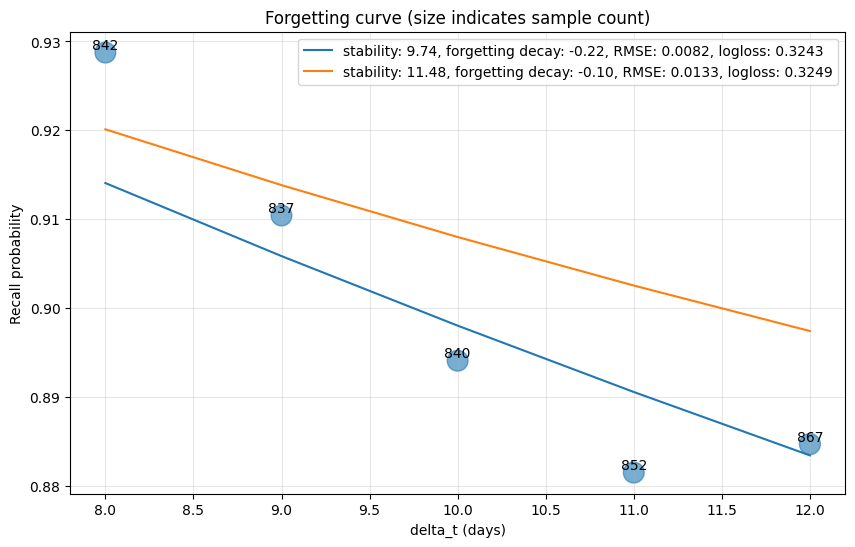

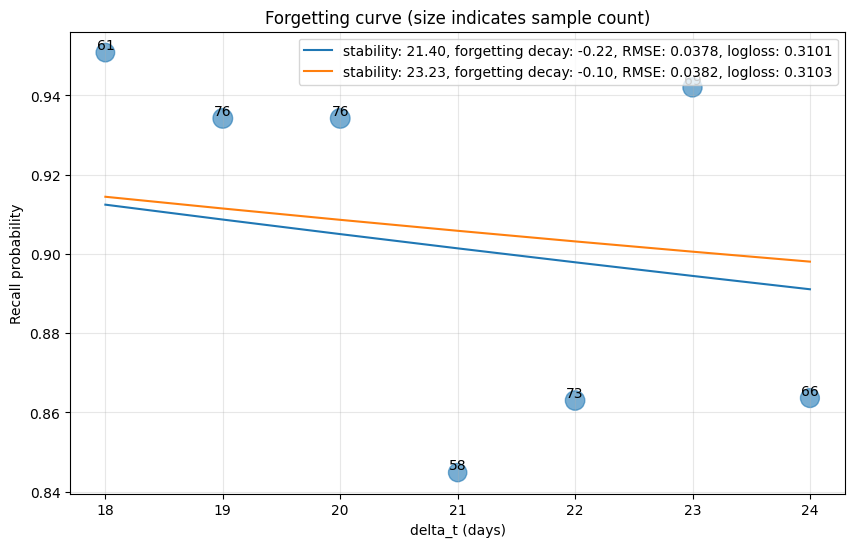

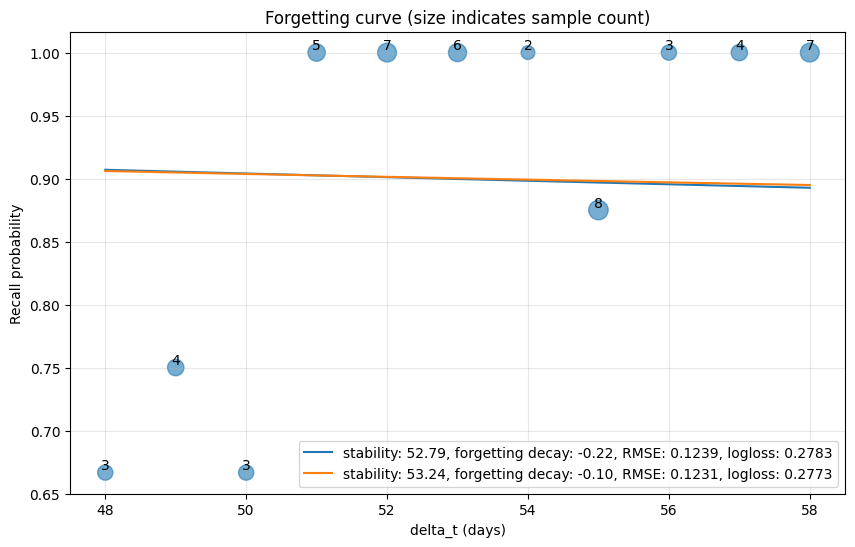

In [8]:
from fsrs_optimizer import power_forgetting_curve
from sklearn.metrics import root_mean_squared_error, log_loss

initial = Optimizer()
initial.dataset = dataset.copy()
initial.w = initial_parameters
loss_before, loss_after = initial.evaluate(save_to_file=False)
trained = Optimizer()
trained.dataset = dataset.copy()
trained.w = trained_parameters
loss_before, loss_after = trained.evaluate(save_to_file=False)
for r_history in ["3", "3,3", "3,3,3"]:
    t_history = (
        test_df[test_df["r_history"] == r_history]["t_history"].value_counts().index[0]
    )
    stabilities = []
    for df in [initial.dataset, trained.dataset]:
        tmp = df[(df["r_history"] == r_history) & (df["t_history"] == t_history)]
        points = tmp.groupby("delta_t")["y"].agg(["mean", "count"])
        stabilities.append(tmp["stability"].unique()[0])
    y_true = points["mean"]
    plt.figure(figsize=(10, 6))
    plt.scatter(
        points.index,
        y_true,
        s=np.sqrt(points["count"] / sum(points["count"])) * 500,
        alpha=0.6,
    )
    for x, y in zip(points.index, y_true):
        plt.text(x, y, points["count"][x], ha="center", va="bottom")

    for s, d in zip(stabilities, [initial_parameters[20], trained_parameters[20]]):
        y_pred = power_forgetting_curve(points.index, s, -d)
        rmse = root_mean_squared_error(y_true, y_pred, sample_weight=points["count"])
        logloss = log_loss(
            tmp["y"],
            power_forgetting_curve(tmp["delta_t"], s, -d),
        )
        plt.plot(
            points.index,
            y_pred,
            label=f"stability: {s:.2f}, forgetting decay: {-d:.2f}, RMSE: {rmse:.4f}, logloss: {logloss:.4f}",
        )
    plt.xlabel("delta_t (days)")
    plt.ylabel("Recall probability")
    plt.title("Forgetting curve (size indicates sample count)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [9]:
from fsrs_optimizer import FSRS
import torch


def calculate_retention(parameters, r_history, t_history, next_interval):
    """Calculate retention for given review history and parameters"""
    fsrs = FSRS(parameters)
    tensor = torch.tensor([t_history, r_history]).transpose(0, 1).unsqueeze(1)
    _, state = fsrs.forward(tensor)
    stability = state[0][0].item()
    retention = power_forgetting_curve(next_interval, stability, -parameters[20])
    print(next_interval, retention)


# Initial parameters
calculate_retention(initial_parameters, [3], [0], 30)
calculate_retention(initial_parameters, [3, 3], [0, 30], 145)

# Trained parameters
calculate_retention(trained_parameters, [3], [0], 30)
calculate_retention(trained_parameters, [3, 3], [0, 30], 145)


# Initial parameters
calculate_retention(initial_parameters, [3], [0], 15)
calculate_retention(initial_parameters, [3, 3], [0, 15], 40)

# Trained parameters
calculate_retention(trained_parameters, [3], [0], 15)
calculate_retention(trained_parameters, [3, 3], [0, 15], 40)

30 0.7915504103679721
145 0.7616836320342888
30 0.8372896559250519
145 0.8031053816897504
15 0.8637188083443708
40 0.866692434992662
15 0.8837007754055552
40 0.8768829891934126


In [10]:
from fsrs_optimizer import next_interval

s = 100
for dr in [0.9, 0.8, 0.7, 0.5]:
    print(f"stability: {s}, desired retention: {dr}")
    ivl = next_interval(s, dr, decay=-initial_parameters[20])
    true_retention = power_forgetting_curve(ivl, s, -initial_parameters[20])
    print(f"initial: {ivl}, true retention: {true_retention:.2f}")
    ivl = next_interval(s, dr, decay=-trained_parameters[20])
    true_retention = power_forgetting_curve(ivl, s, -initial_parameters[20])
    print(f"trained: {ivl}, true retention: {true_retention:.2f}")
    print()

stability: 100, desired retention: 0.9
initial: 100, true retention: 0.90
trained: 100, true retention: 0.90

stability: 100, desired retention: 0.8
initial: 286, true retention: 0.80
trained: 441, true retention: 0.75

stability: 100, desired retention: 0.7
initial: 660, true retention: 0.70
trained: 1805, true retention: 0.58

stability: 100, desired retention: 0.5
initial: 3622, true retention: 0.50
trained: 51957, true retention: 0.28

